# Introduction Bayesian Optimzation
1. Noisy Observations
2. Gaussian Processes
3. Acquisition Functions


## 1. Noisy Observations

1) Observations / evaluations / experiments
Noisy evaluation as $𝐽_𝑖=𝐽(𝜃_𝑖 )+𝜖_𝑖  ,  𝜖_𝑖∼𝒩(0,𝜎_n^2 )$
Data set from observations: store all relevant information $𝒟_𝑖=\{(𝜃_1,𝐽_1 ), …,(𝜃_𝑖,𝐽_𝑖 )\}$

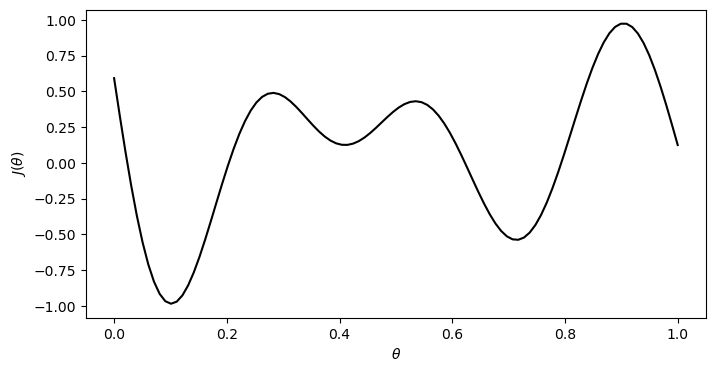

In [1]:
# Example test function
import numpy as np
import matplotlib.pyplot as plt

# fix seed for reproduciblity
np.random.seed(1)


def test_function(theta):
    
    return (-(1.4-4*(theta-1)**2) *np.sin(16*(theta-1))+0.2)/1.6

def plot_test_function():
    fig, axs = plt.subplots(1, 1, figsize=(8, 4))
    x = np.linspace(0, 1, 100)
    axs.plot(x, test_function(x), label=r'$J(\theta)$', color='black')
    axs.set_xlabel(r'$\theta$')
    axs.set_ylabel(r'$J(\theta)$')
    return fig, axs

fig, axs = plot_test_function()


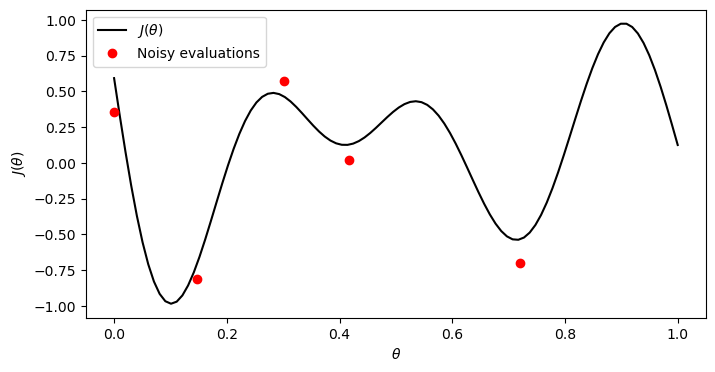

In [2]:
# Noisy test function
def noisy_test_function(theta, noise_level=0.1):
    noise = np.random.normal(0, noise_level, size=theta.shape)
    return test_function(theta) + noise

# plot the noisy test function evaluations
fig, axs = plot_test_function()
training_points = 5  # Number of training points
theta_train = np.random.uniform(0, 1, training_points)
y_train = noisy_test_function(theta_train)

axs.plot(theta_train, y_train, 'o', label='Noisy evaluations', color='red')
axs.legend()



## 2. Probabilistic surrogate model: Gaussian Processes

Formal definition: 
A Gaussian Process is a distribution over functions. 
It is uniquely defined by its mean vector and covariance function (kernel). A function k(\dot,\dot) is a valid covariance function if the corresponding matrix kxx is positive semidefinite (k_XX >= 0)


Inituition: 
A GP is a probablistic surrogate model, which we use to model our unknown function. 
The mean function shows us where in expectation the function is, the variance gives us an uncertainty estimate.  
At points where we have data, the uncertainty is low, at points where we did not observe data, the uncertainty is high. 
The covariance or se_kernel function determines, how the functions we can model look like. 


One popular se_kernel function is the squared exponential se_kernel. 

$ k(x_1, x_2) = \sigma_f^2\mathrm{ exp}(-(x_1 - x_2)^2/(2l^2)) $


In [3]:
def se_kernel(X1, X2, l=0.1, sigma_f=0.5):
    """ Squared Exponential se_kernel function.
    Input:
        X1: (n1, d) array of n1 points in d dimensions
        X2: (n2, d) array of n2 points in d dimensions
        l: length scale parameter
        sigma_f: signal variance parameter
    Output:
        (n1, n2) matrix of se_kernel values between points in X1 and X2
    """
    
    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * sqdist)

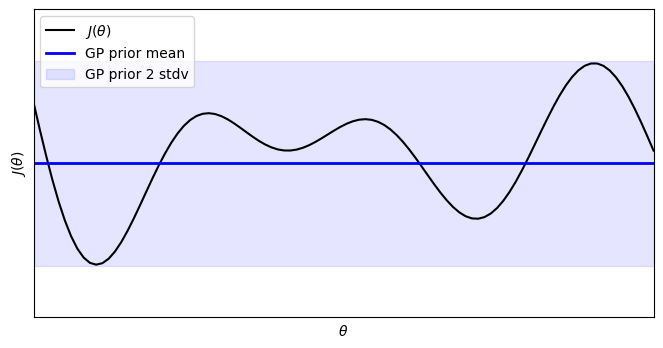

In [4]:
# modeling with Gaussian Process (GP prior)
theta_test = np.linspace(0, 1, 100).reshape(-1, 1)
# Define mean and variance
f_mean = np.zeros_like(theta_test).reshape(-1)  # Zero mean for simplicity
f_var = se_kernel(theta_test, theta_test)  # Covariance matrix for the test points
f_stdv = np.sqrt(np.diag(f_var))

# plot samples
fig, axs = plot_test_function()
axs.set_xlim([0, 1])
axs.set_ylim([-1.5, 1.5])
axs.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

axs.plot(theta_test, f_mean, color="blue", lw=2, label="GP prior mean")
axs.fill_between(theta_test.reshape(-1), f_mean - 2 * f_stdv, f_mean + 2 * f_stdv, color="blue", alpha = 0.1, label="GP prior 2 stdv")
axs.legend()

From the prior distribution we can draw samples. 

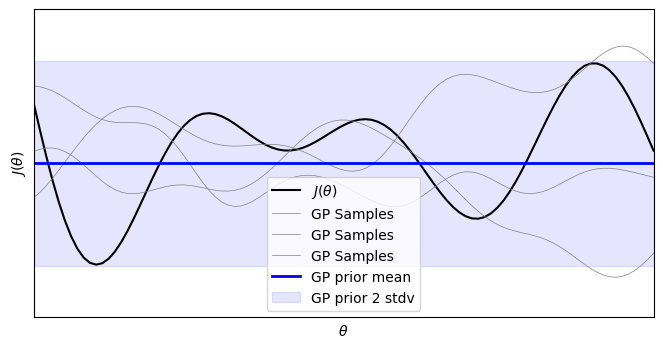

In [5]:
# Generate samples from the GP
num_samples = 3
samples = np.random.multivariate_normal(f_mean, f_var, size=num_samples)

# plot samples
fig, axs = plot_test_function()
axs.plot(theta_test, samples.T, color="gray", linewidth=0.5, label='GP Samples')
axs.set_xlim([0, 1])
axs.set_ylim([-1.5, 1.5])
axs.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

axs.plot(theta_test, f_mean, color="blue", lw=2, label="GP prior mean")
axs.fill_between(theta_test.reshape(-1), f_mean - 2 * f_stdv, f_mean + 2 * f_stdv, color="blue", alpha = 0.1, label="GP prior 2 stdv")
axs.legend()


## 2.2 The GP posterior 

Here you can find an simple explanation for calculating the GP posterior. 
Refer to: Rasmussen, C. E., Williams, C. K. I, Gaussian Processes for Machine Learning, Chapter 2.2  Section Prediction using Noisy Observations

In [6]:
# GP posterior calculation
def calculate_gp_posterior(theta_train, y_train, theta_test, se_kernel, noise, n_samples=3):
    # matrices
    k_xx = se_kernel(theta_test, theta_test)
    k_Xx = se_kernel(theta_train, theta_test)
    k_XX = se_kernel(theta_train, theta_train)

    # mean
    L = np.linalg.cholesky(k_XX + np.eye(k_XX.shape[0]) * noise **2)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    f_mean = (k_Xx.T @ alpha).reshape(-1)

    # cov
    v = np.linalg.solve(L, k_Xx)
    f_var = k_xx - v.T @ v

    # get samples
    samples = np.random.multivariate_normal(f_mean.reshape(-1), f_var, size=n_samples)
    return f_mean, f_var, samples

In [7]:
# plot GP posterior
def plot_gp_posterior(theta_train, y_train, theta_test, se_kernel, noise=0.1, n_samples=3):
    theta_train = theta_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    theta_test = theta_test.reshape(-1, 1)
    f_mean, f_var, samples = calculate_gp_posterior(theta_train, y_train, theta_test, se_kernel, noise, n_samples)
    
    fig, axs = plot_test_function()
    
    axs.plot(theta_test, f_mean, color="blue", lw=2, label='GP Mean')
    axs.fill_between(theta_test.reshape(-1), 
                     f_mean - 2 * np.sqrt(np.diag(f_var)), 
                     f_mean + 2 * np.sqrt(np.diag(f_var)), 
                     color="blue", alpha=0.1, label='GP Stdv')
    axs.plot(theta_test, samples.T, color="gray", linewidth=0.5, label='GP Samples')
    axs.plot(theta_train, y_train, 'o', label='Training data', color='black', markersize=8)
    # disable ticks and labels
    axs.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    axs.set_ylim([-1.5, 1.5])
    axs.set_xlim([0, 1])
    #axs.legend()
    return fig, axs


Test yourself, what happens if you add more data points to the GP. 

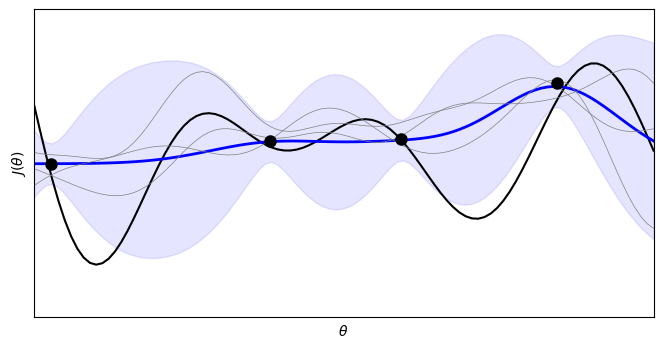

In [8]:
num_points = 4 # Vary the number of training points

# Generate training data 
theta_train_gp = np.random.uniform(0, 1, num_points)
y_train_gp = noisy_test_function(theta_train_gp)

# Plot GP posterior with training data
fig, axs = plot_gp_posterior(theta_train_gp, y_train_gp, theta_test, se_kernel, noise=0.1, n_samples=3)



The kernel function has two hyperparameter, the lengthscale $l$ and the outputscale $\sigma_f$. 
These hyperparameters determine, how the modelled function look like. 

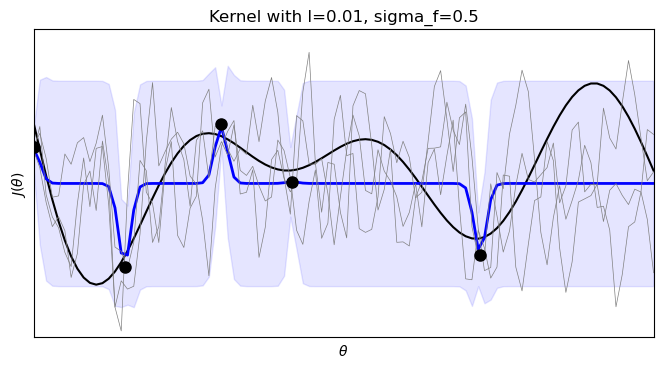

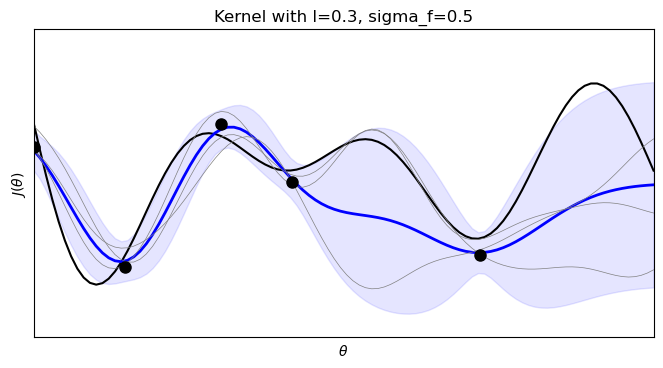

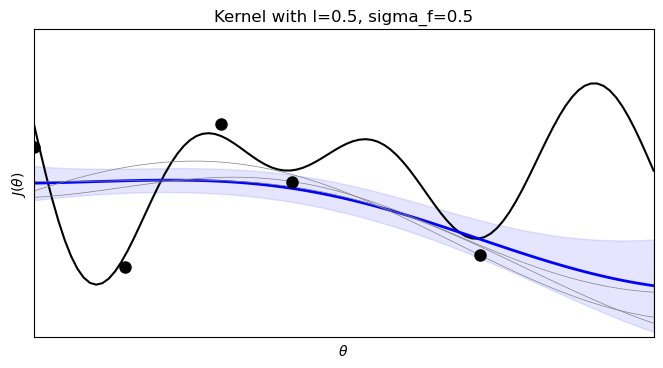

In [9]:
kernel1 = lambda X1, X2: se_kernel(X1, X2, l=0.01, sigma_f=0.5)
# plot GP posterior with different se_kernel parameters
fig, axs = plot_gp_posterior(theta_train, y_train, theta_test, kernel1, noise=0.1, n_samples=3)
axs.set_title('Kernel with l=0.01, sigma_f=0.5')
plt.show()

kernel2 = lambda X1, X2: se_kernel(X1, X2, l=0.1, sigma_f=0.5)
fig2, axs2 = plot_gp_posterior(theta_train, y_train, theta_test, kernel2, noise=0.1, n_samples=3)
axs2.set_title('Kernel with l=0.3, sigma_f=0.5')
plt.show()

kernel3 = lambda X1, X2: se_kernel(X1, X2, l=0.5, sigma_f=0.5)
fig3, axs3 = plot_gp_posterior(theta_train, y_train, theta_test, kernel3, noise=0.1, n_samples=3)
axs3.set_title('Kernel with l=0.5, sigma_f=0.5')
plt.show()

Hyperparameter Optimization

Optimized length scale (l): 0.01
Optimized signal variance (sigma_f): 0.5619370292211009
Optimized noise parameter (noise): 0.07651889373603633


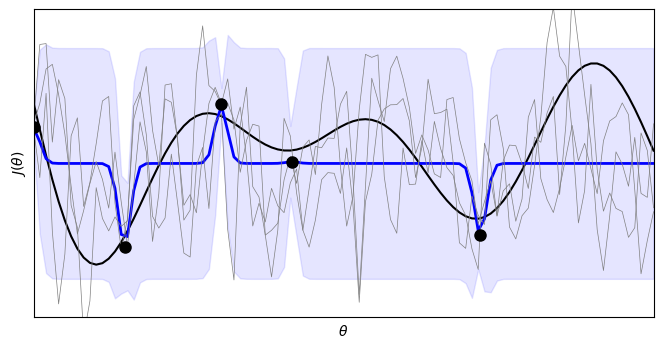

In [10]:
import numpy as np
from scipy.optimize import minimize

#theta_train = np.random.uniform(0, 1, 10)  # Random training points
#y_train = noisy_test_function(theta_train, noise_level=0.1)  # Noisy evaluations of the test function
# Define negative log marginal likelihood function
def neg_log_likelihood(params, theta_train, y_train, se_kernel):
    l, sigma_f, noise = params[0], params[1], params[2]
    K = se_kernel(theta_train, theta_train, l=l, sigma_f=sigma_f) + noise**2 * np.eye(len(theta_train))
    try:
        L = np.linalg.cholesky(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
        log_likelihood = -0.5 * y_train.T @ alpha - np.sum(np.log(np.diag(L))) - len(theta_train) / 2 * np.log(2 * np.pi)
        return -log_likelihood.item()
    except Exception:
        return np.inf

# Initial parameters and bounds for optimization
initial_params = np.array([0.3, 0.5, 0.01])  # initial values for l, sigma_f, noise
bounds = ((1e-2, 1.0), (1e-2, 1.0), (1e-5, 1e-1))  # bounds for parameters

theta_train = theta_train.reshape(-1, 1)  # Ensure theta_train is a 2D array
y_train = y_train.reshape(-1, 1)  # Ensure y_train is a 2D array
# Perform optimization
result = minimize(neg_log_likelihood, initial_params, args=(theta_train, y_train, se_kernel), bounds=bounds, method='L-BFGS-B')

# Extract optimized hyperparameters
l_opt, sigma_f_opt, noise_opt = result.x

print(f"Optimized length scale (l): {l_opt}")
print(f"Optimized signal variance (sigma_f): {sigma_f_opt}")
print(f"Optimized noise parameter (noise): {noise_opt}")

kernel4 = lambda X1, X2: se_kernel(X1, X2, l=l_opt, sigma_f=sigma_f_opt)
fig, axis = plot_gp_posterior(theta_train.flatten(), y_train, theta_test, kernel4, noise=noise_opt, n_samples=3) 
plt.show()

# 3. Acquisition Function

How can we leverage uncertainty in the GP to find the optimum?

A standard loop looks like this: 

GP with some data points
for i iterations do: 
    -  x_next = max(acquisition function)
    -  measure y_next
    -  update Data set with new point (x_next, y_next)
    - Update GP model

What is an acquisition function? 
The acquistion function is an cheap to evaluate function, that tells us where to sample next. 
Which obvious possibilities do we have to use the information from the GP as an acquisition function?

### First idea: use the mean as an acquisition function

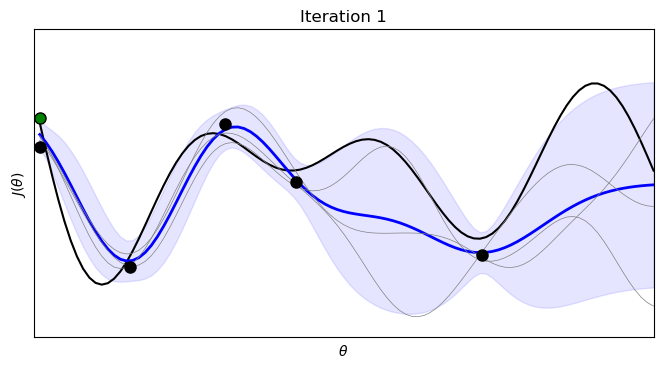

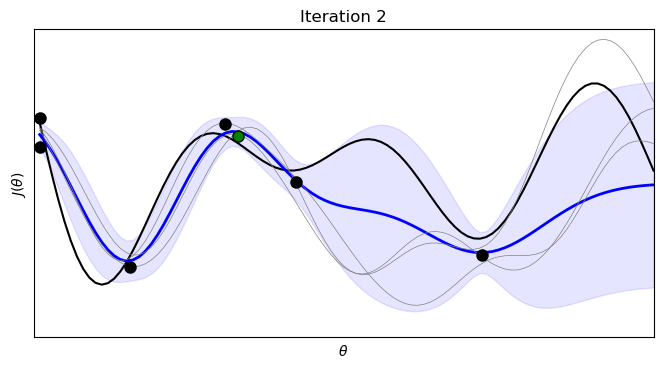

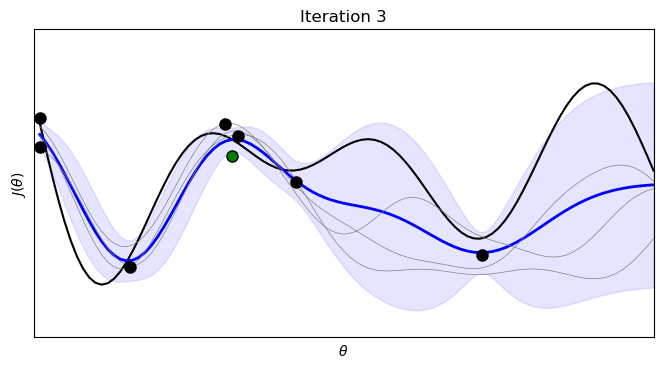

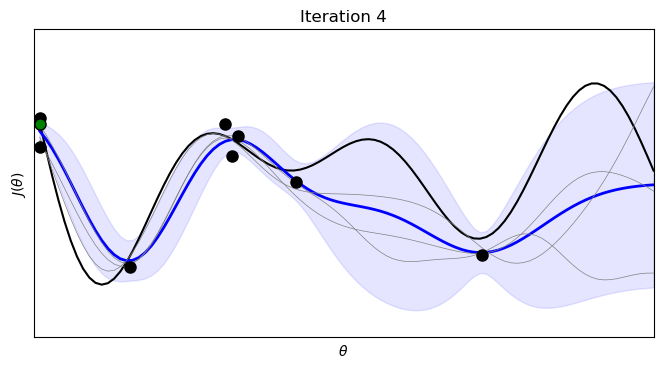

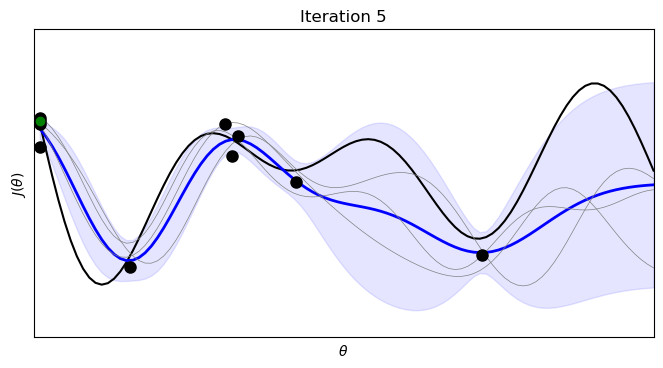

In [11]:
# write a BO loop with the mean as the acquisition function
# initial training points

iterations = 5
theta_train_mean = theta_train
y_train_mean = y_train
for i in range(iterations):
    # search maximum of mean
    x_next = np.linspace(0, 1, 100)[np.argmax(f_mean)]
    y_next = noisy_test_function(np.array([x_next]), noise_level=0.1)
    theta_train_mean = theta_train_mean.flatten()
    y_train_mean = y_train_mean.flatten()
    theta_train_mean = np.append(theta_train_mean, x_next).reshape(-1, 1)
    y_train_mean = np.append(y_train_mean, y_next).reshape(-1, 1)
    # update posterior
    f_mean, f_var, samples = calculate_gp_posterior(theta_train_mean, y_train_mean, theta_test, se_kernel, noise=0.1, n_samples=3)
    # plot updated posterior
    fig, axs = plot_gp_posterior(theta_train_mean, y_train_mean, theta_test, se_kernel, noise=0.1, n_samples=3)
    axs.set_xlim([-0.01, 1])
    axs.plot(x_next, y_next, 'o', label='Next point', color='green')
    axs.set_title(f'Iteration {i+1}')
    plt.show()

Observation: This leads to full exploitation. But we do not find the optimum. 

### Second idea: Use the variance


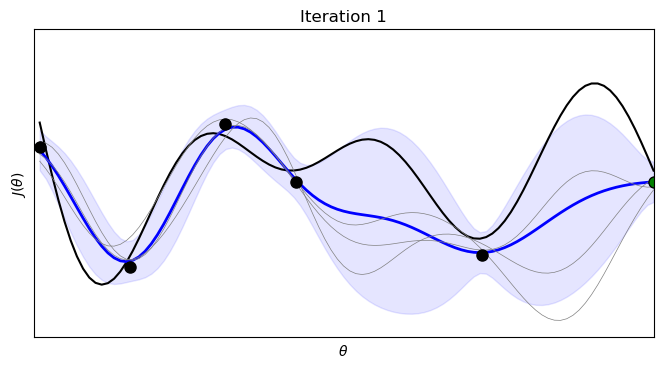

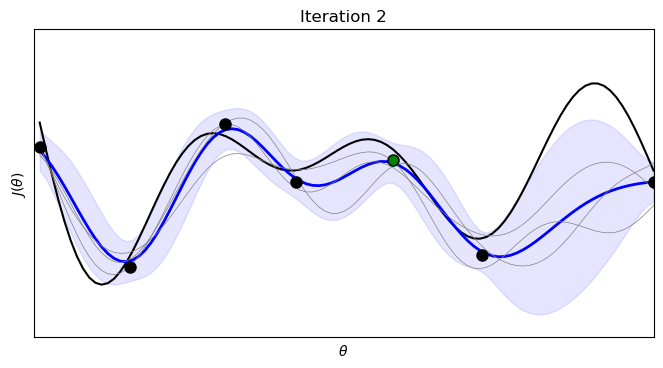

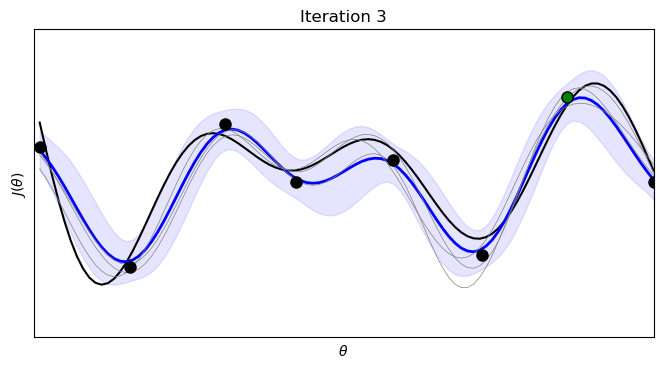

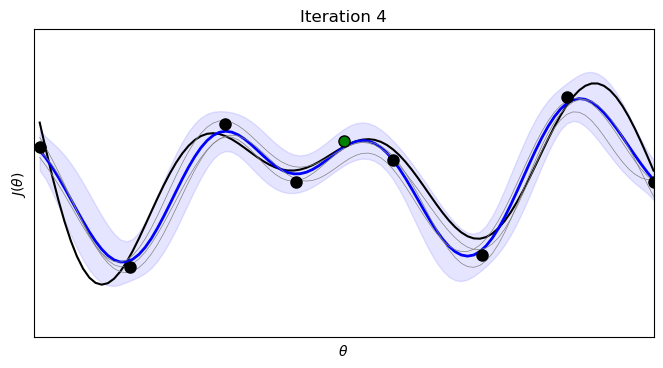

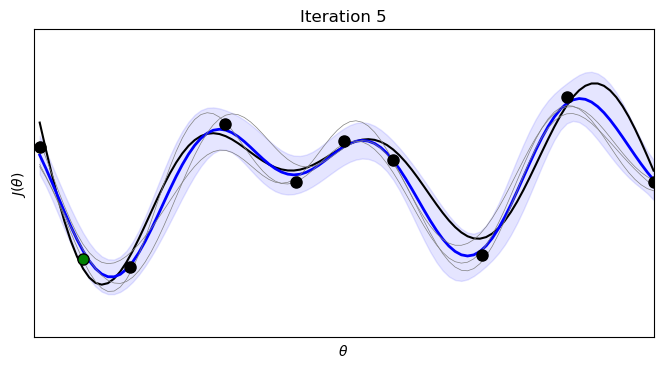

In [12]:
# write a BO loop with the maximum variance as the acquisition function
iterations = 5
theta_train_variance = theta_train
y_train_variance = y_train

f_mean, f_var, samples = calculate_gp_posterior(theta_train_variance.reshape(-1,1), y_train_variance.reshape(-1,1), theta_test, se_kernel, noise=0.1, n_samples=3)
f_stdv = np.sqrt(np.diag(f_var))

for i in range(iterations):
    # search maximum of mean
    x_next = np.linspace(0, 1, 100)[np.argmax(f_stdv)] # there are smarter ways to search the optimum
    y_next = noisy_test_function(np.array([x_next]), noise_level=0.1) 
    theta_train_variance = theta_train_variance.flatten()
    y_train_variance = y_train_variance.flatten()
    theta_train_variance = np.append(theta_train_variance, x_next).reshape(-1, 1)
    y_train_variance = np.append(y_train_variance, y_next).reshape(-1, 1)
    # update posterior
    f_mean, f_var, samples = calculate_gp_posterior(theta_train_variance, y_train_variance, theta_test, se_kernel, noise=0.1, n_samples=3)
    f_stdv = np.sqrt(np.diag(f_var))
    # plot updated posterior
    fig, axs = plot_gp_posterior(theta_train_variance, y_train_variance, theta_test, se_kernel, noise=0.1, n_samples=3)
    axs.set_xlim([-0.01, 1])
    #axs.plot(theta_test, f_stdv, label='GP Std Dev', color='orange')
    axs.plot(x_next, y_next, 'o', label='Next point', color='green')
    axs.set_title(f'Iteration {i+1}')
    plt.show()

Observation: Using just the variance leads to full exploration. Which is nice in 1D, but in more dimensions we would like to find the optimum of the function fast and not explore the whole parameter space. 

### The UCB-Acquisition Function

$ \alpha(x) = \mu(x) + \beta \sigma(x)$

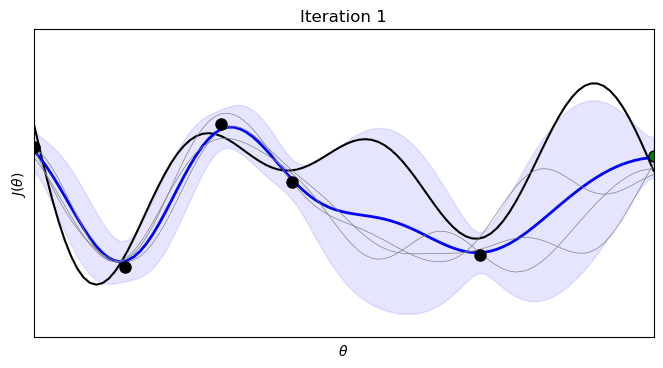

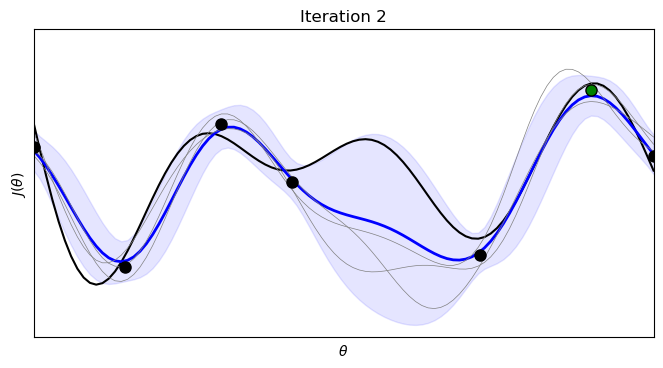

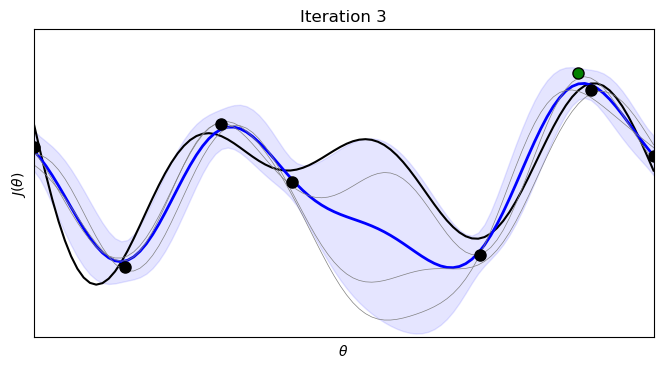

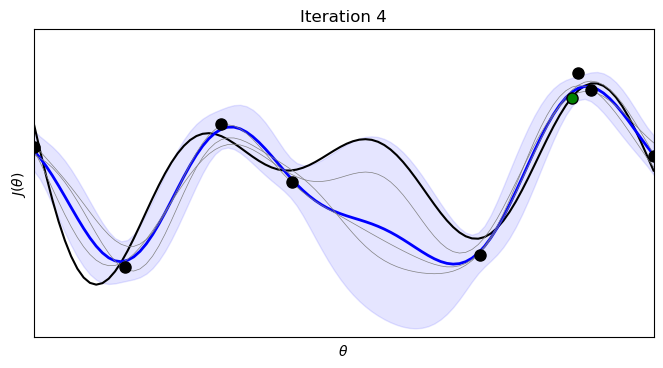

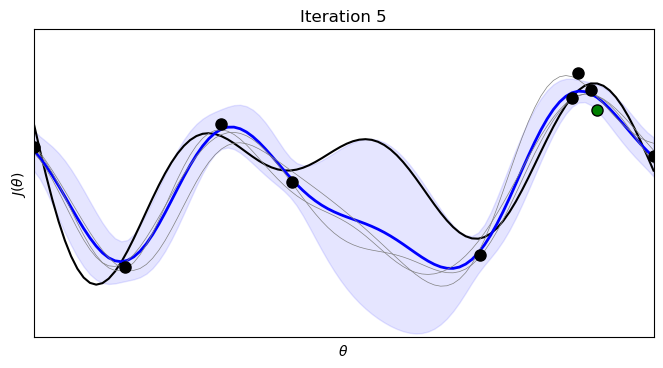

In [13]:
# write a BO loop with the maximum variance as the acquisition function
iterations = 5
beta = 2 # Task for you: Vary beta and observe the effect on the acquisition function
theta_train_ucb = theta_train
y_train_ucb = y_train

f_mean, f_var, samples = calculate_gp_posterior(theta_train_ucb.reshape(-1,1), y_train_ucb.reshape(-1,1), theta_test, se_kernel, noise=0.1, n_samples=3)
f_stdv = np.sqrt(np.diag(f_var))


for i in range(iterations):
    # search maximum of mean
    x_next = np.linspace(0, 1, 100)[np.argmax(f_mean + beta * f_stdv)] # there are smarter ways to search the optimum
    y_next = noisy_test_function(np.array([x_next]), noise_level=0.1) 
    theta_train_ucb = theta_train_ucb.flatten()
    y_train_ucb = y_train_ucb.flatten()
    theta_train_ucb = np.append(theta_train_ucb, x_next).reshape(-1, 1)
    y_train_ucb = np.append(y_train_ucb, y_next).reshape(-1, 1)
    # update posterior
    f_mean, f_var, samples = calculate_gp_posterior(theta_train_ucb, y_train_ucb, theta_test, se_kernel, noise=0.1, n_samples=3)
    f_stdv = np.sqrt(np.diag(f_var))
    # plot updated posterior
    fig, axs = plot_gp_posterior(theta_train_ucb, y_train_ucb, theta_test, se_kernel, noise=0.1, n_samples=3)
    axs.plot(x_next, y_next, 'o', label='Next point', color='green')
    axs.set_title(f'Iteration {i+1}')
    plt.show()


### Optimizing the acquisition function

Finding the optimum of the acquisition function is easier than finding the optimum of the true function as we can use the model and evaluate this more often.
In this example, we used a grid to find the optimum and evaluate the GP. However, this is not a feasible solution in higher dimensions
Toolboxes like BoTorch use multistrart gradient descent to optimize the acquisition function more efficiently. 